In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
%pip install -r /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/requirements.txt

In [3]:
import os
import sys
sys.path.insert(0, '/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates')
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
#from sklearn.externals import joblib
import joblib
from scipy.stats import halfcauchy
from mne.decoding import UnsupervisedSpatialFilter
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from utils import add_features
from sklearn.metrics import ConfusionMatrixDisplay
from state_prediction import *
from sliding_window_classifiers import *
import gc
np.random.seed(100)



# DEFAULT PARAMETERS - OVERRRIDEN BY PAPERMILL EXECUTION
session_id = '001'  # ID of the scanning session
output_dir = '/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives'  # Where the output data should go
n_stim = 14  # Number of stimuli
classifier_window = [-5, 6]  # Additional timepoints to use as features
classifier_center_idx_setting = 20  # The center index of the classification window, post stimulus onset
n_pca_components = [30, 60]  # Range of PCA components to try when optimising the classifier
param_optimisation_cv = 5  # Folds of CV to use in optimisation
classifier_regularisation = 'l1'  # Type of regularisation to use, l1 or l2
classifier_multiclass = 'ovr'  # Type of multi-class approach to use, ovr for one-vs-the-rest or multiclass
confusion_matrix_cv = 5  # CV to use for making the confusion matrix
n_iter_search = 100  # Number of iterations of the random search parameter optimisation procedure
cores = 1  # Number of cores to use for parallel processing
os.environ['OMP_NUM_THREADS'] = str(cores)
list_mean_accuracy = []

028
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-028/localiser/sub-028_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Mean accuracy = 0.46555555555555556


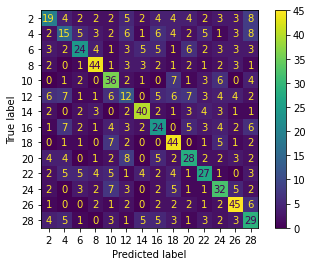

/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/classifier/classifier_idx_70/sub-028_classifier_idx_70.pkl
/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/localiser_classifier_performance/confusion_matrix/classifier_idx_70
/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/localiser_classifier_performance/confusion_matrix/sub-028_confusion_matrix_idx_70.pkl [[0.296875   0.06349206 0.03076923 0.03030303 0.03174603 0.078125
  0.03125    0.0625     0.0625     0.06349206 0.03125    0.04615385
  0.04545455 0.12307692]
 [0.03125    0.23809524 0.07692308 0.04545455 0.03174603 0.09375
  0.015625   0.09375    0.0625     0.03174603 0.078125   0.01538462
  0.04545455 0.12307692]
 [0.046875   0.03174603 0.36923077 0.06060606 0.01587302 0.046875
  0.078125   0.078125   0.015625   0.0952381  0.03125    0.04615385
  0.04545455 0.04615385]
 [

In [7]:
for session_id_int in range(28, 29):
    gc.collect()
    session_id = '{:03d}'.format(session_id_int)
    print(session_id)

    # Get data
    localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{}', 'localiser', 'sub-{}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id,session_id))  

    # Get epoch data
    X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
    y_raw = localiser_epochs.events[:, 2]  # Get event types

    # select events and time period of interest
    picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
    event_selector = (y_raw < n_stim * 2 + 1)
    X_raw = X_raw[event_selector, ...]
    y_raw = y_raw[event_selector]
    X_raw = X_raw[:, picks_meg, :]

    assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

    print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                    np.unique(y_raw)))

    times = localiser_epochs.times

    prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
    classifier_center_idx = prestim_samples + classifier_center_idx_setting


    # Get data
    X, y = (X_raw.copy(), y_raw.copy())
    X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

    #Create null data
    """ X_null = np.zeros((X.shape[0], 272, np.sum(np.abs(classifier_window))))
    for n, i in enumerate(np.random.randint(np.sum(np.abs(classifier_window)), prestim_samples, X.shape[0])):
        X_null[n, :, :] = X_raw[n, :, i:np.sum(np.abs(classifier_window)) + i]
    y_null = np.ones(X_null.shape[0]) * 99
    X = np.vstack([X, X_null])
    y = np.hstack([y, y_null]) """
    
    # Create a pipiline that combines PCA, feature augmentation, scaling, and the logistic regression classifier
    clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                        FunctionTransformer(add_features, validate=False), StandardScaler(), 
                        LogisticRegression(multi_class=classifier_multiclass, C=0.1, penalty=classifier_regularisation, solver='saga', max_iter=100000, tol=0.2, class_weight="balanced"))
    # # Parameter distributions passed to the random search procedure
    param_dist = {"unsupervisedspatialfilter__estimator__n_components": range(*n_pca_components),
              "logisticregression__C": halfcauchy(scale=5)}

    # # run randomized search
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=param_optimisation_cv, n_jobs=8, scoring='accuracy', verbose=True)
    random_search.fit(X, y)

    # # Produce a dataframe of the search results
    results = pd.DataFrame(random_search.cv_results_)

    #print("Parameter optimisation done")


    init_notebook_mode(connected=True)

    trace = go.Mesh3d(x=results.param_logisticregression__C,
                    y=results.param_unsupervisedspatialfilter__estimator__n_components,
                    z=results.mean_test_score, 
                    color='#275fb5', opacity=0.20)

    layout = go.Layout(
        title='Hyperparameter optimisation results',
        autosize=True,
        width=700,
        height=700,
        scene = dict(
        xaxis = dict(
            title='Logistic regression C'),
        yaxis = dict(
            title='PCA N components'),
        zaxis = dict(
            title='Mean accuracy'),)
    )

    fig = go.Figure(data=[trace], layout=layout)
    #iplot(fig)


    clf.set_params(**random_search.best_params_)
    
    # Get predictions with 5 fold CV
    y_pred = cross_val_predict(clf, X, y, cv=confusion_matrix_cv)
    mean_conf_mat = confusion_matrix(y, y_pred)
    mean_accuracy = accuracy_score(y[y != 99], y_pred[y != 99])
    mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
    list_mean_accuracy.append(mean_accuracy)
    print("Mean accuracy = {0}".format(mean_accuracy))
        
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
    plt.show()


    #save
    if not os.path.exists(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx))):
        os.makedirs(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx)))
    joblib.dump(random_search.best_estimator_ , os.path.join(output_dir, 'classifier', 
                                                            'classifier_idx_{0}'.format(classifier_center_idx), 'sub-{0}_classifier_idx_{1}.pkl').format(session_id, classifier_center_idx))

    accuracy_data = {
        'mean_accuracy': mean_accuracy,
        'best_C': random_search.best_params_['logisticregression__C'],
        'best_n_components': random_search.best_params_['unsupervisedspatialfilter__estimator__n_components']
    }

    with open(os.path.join(output_dir, 'classifier', 'sub-{0}_classifier_info.json'), 'w') as f:
        json.dump(accuracy_data, f)

    if not os.path.exists(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx))):
        os.makedirs(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx)))
    np.save(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'sub-{0}_confusion_matrix_idx_{1}.pkl').format(session_id, classifier_center_idx), mean_conf_mat)

    print(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx), 'sub-{0}_classifier_idx_{1}.pkl').format(session_id, classifier_center_idx))
    print(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx)))
    print(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'sub-{0}_confusion_matrix_idx_{1}.pkl').format(session_id, classifier_center_idx), mean_conf_mat)


Loop to transform X data for each subject without running classification

In [5]:
for session_id_int in range(3, 28):
    gc.collect()
    session_id = '{:03d}'.format(session_id_int)
    print(session_id)

    # Get data
    localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{}', 'localiser', 'sub-{}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id,session_id))  

    # Get epoch data
    X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
    y_raw = localiser_epochs.events[:, 2]  # Get event types

    # select events and time period of interest
    picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
    event_selector = (y_raw < n_stim * 2 + 1)
    X_raw = X_raw[event_selector, ...]
    y_raw = y_raw[event_selector]
    X_raw = X_raw[:, picks_meg, :]

    assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

    print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                    np.unique(y_raw)))

    times = localiser_epochs.times

    prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
    classifier_center_idx = prestim_samples + classifier_center_idx_setting


    # Get data
    X, y = (X_raw.copy(), y_raw.copy())
    X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

    # Preprocess using _clf
    _clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                        FunctionTransformer(add_features, validate=False), StandardScaler())
    
    # Add the new X to a list or something
    X = _clf.fit_transform(X)


003
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-003/localiser/sub-003_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]
004
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-004/localiser/sub-004_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not

In [6]:
X

array([[ 2.50846181,  2.05718294,  2.56886584, ...,  2.11918576,
        -2.38489016,  1.64248034],
       [ 0.43129448,  1.12020636,  0.47919791, ...,  0.24211056,
        -2.46820812, -1.67493435],
       [-0.67813082, -0.11508109, -0.04874712, ..., -0.74876109,
         1.22736961,  1.80851397],
       ...,
       [-0.16096224,  0.02889162,  0.70176447, ...,  1.24219955,
        -0.87007738, -0.40254775],
       [ 0.87180427,  1.88516883,  2.04207041, ...,  0.6974486 ,
         1.53365982,  1.25026887],
       [ 0.4332045 ,  0.51719354,  0.65625809, ...,  0.56115682,
        -0.11862512, -0.05132351]])